# Enhanced Portfolio Optimization


<u>To Do<u/> <br>
- [x] Import return data.
- [x] Train-test-split of data.
- [ ] Choosing EPO shrinkage parameter $w$ using train data.
- [ ] Calculating shrunk variance-covariance matrix for each step in test data.
- [ ] Calculate EPO weights for each time step in test data.
- [ ] Calculate EPO realized return for each time step in test data.

<u>Notes<u/>
* Notation in accordance with Enhanced Portfolio Optimization (Pedersen, Babu, Levine, 2017)
    
<u>Questions<u/>
* Shrinking the correlation matrix to 0 gives the highest sharpe-ratio. This contradicts the findings of EPO-paper, where shrinkage is suggested to be 0.75. What am I missing here?

# Modules and functions

In [1]:
import sys
from unipath import Path

# append codelib to sys path ~ will only work if this jupyter notebook path is sys.path[0]
p = Path(sys.path[0])
codelib_path = str(p.parent + Path('\\codelib'))
sys.path.insert(0, codelib_path)

# import codelib
from helpers import *
from mean_variance import *
import enhanced_portfolio_optimization as epo

# other modules
import numpy as np
import matplotlib.pyplot as plt

# 1. Data

Now the returns are stores in an array there columns are the return series of each asset.

$$
\text{ret} = 
\begin{bmatrix} 
r_{t0}^1 & r_{t0}^2 & \dots & r_{t0}^N \\ 
r_{t1}^1 & r_{t1}^2 & \dots & r_{t1}^N \\ 
\vdots & \vdots & \ddots &  \vdots \\ 
r_{T}^1 & r_{T}^2 & \dots & r_{T}^N \\ 
\end{bmatrix}
$$

In [2]:
# setting dates
start = "2000-01-01"
end   = "2022-01-01"
port  = "5_Industry_Portfolios"

# pulling data
df = pdr.famafrench.FamaFrenchReader(port, start, end).read()[0]
df = df.replace(-99.99,0) # replace nan values
df = df / 100 # changing format to decimals

# risk free rate
rf = 0.0001

# returns in array
ret = df.to_numpy()

# 3. Choosing EPO shrinkage parameter

**Goal**<br>
The EPO shrinkage parameter $w$ is choosen such that the sharpe-ratio is maximized.<br>

**Protocol**<br>
1. Calculate variance-covariance matrix for given returns.
2. Vector of mean and variance.




In [3]:
mu = np.mean(ret, axis=0)

shrinkage = []
sharpe_ratio = []

for shr in np.linspace(0.0, 0.90, 100):
    sharpe = epo.tangency_portfolio_sharpe_ratio(mu, ret, rf, False, shr)
    shrinkage.append(shr)
    sharpe_ratio.append(sharpe)

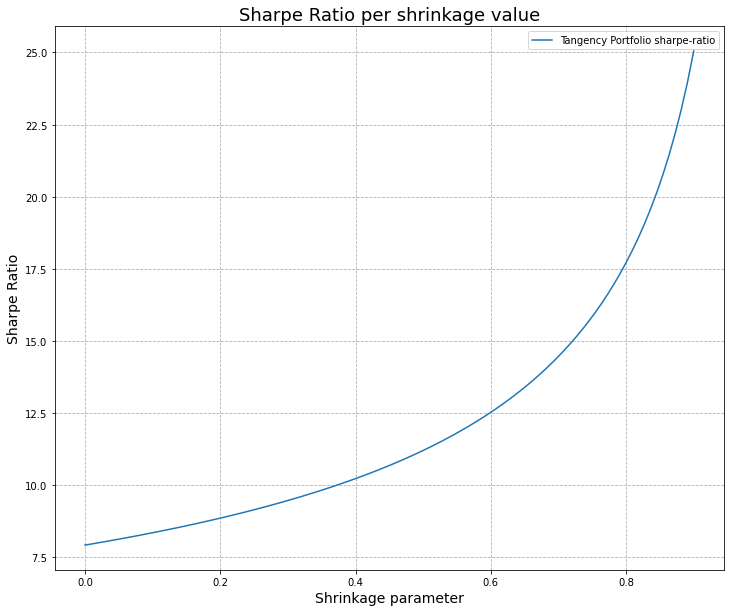

In [4]:
plt.figure(figsize=(12,10))

plt.plot(shrinkage, sharpe_ratio, label="Tangency Portfolio sharpe-ratio")

plt.title("Sharpe Ratio per shrinkage value", size=18)
plt.ylabel("Sharpe Ratio", size=14)
plt.xlabel("Shrinkage parameter", size=14)

plt.legend()
plt.grid(linestyle="--")

plt.show()